# Two-Level GLM (from Nilearn)

In this tutorial, we demonstrate how to write pydra tasks for the first level (subject-level) GLM and the second level (group-level) GLM in Nilearn. We use the data from [Balloon Analog Risk-taking Task](https://openneuro.org/datasets/ds000001/versions/1.0.0). 
Basic information about this dataset:
- 16 subjects
- 3 runs
- functional scan TR: 2.3 
- num of functional scan: 300

In [1]:
import nest_asyncio
nest_asyncio.apply()

## Preparation

Import packages that will be used globally and set up output directory

In [2]:
import warnings
import sys 
if not sys.warnoptions:
    warnings.simplefilter("ignore")

import os, glob
import datetime
import random
import pydra
from pydra import Workflow
from pydra.engine.specs import File, MultiInputFile, MultiOutputFile
import typing as ty
from pathlib import Path
import datalad.api as dl

import numpy as np
import pandas as pd
import nibabel as nib
from scipy.stats import norm
from nilearn.interfaces.fmriprep import load_confounds_strategy
from nilearn.image import load_img, get_data, math_img, threshold_img
from nilearn.glm.first_level import make_first_level_design_matrix, FirstLevelModel
from nilearn.glm.second_level import SecondLevelModel, non_parametric_inference
from nilearn.glm.contrasts import compute_fixed_effects
from nilearn.plotting import plot_stat_map, plot_glass_brain

In [3]:
# get current directory
pydra_tutorial_dir = os.path.dirname(os.getcwd())

# set up output directory
workflow_dir = Path(pydra_tutorial_dir) / 'outputs'
workflow_out_dir = workflow_dir / '7_glm' /'results'

# create folders if not exit
os.makedirs(workflow_out_dir, exist_ok=True)

### Download the data

[DataLad](http://handbook.datalad.org/en/latest/index.htmlhttp://handbook.datalad.org/en/latest/index.html) is often used in those cases to download data. Here we use its [Python API](http://docs.datalad.org/en/latest/modref.htmlhttp://docs.datalad.org/en/latest/modref.html).

We need the following data: 

1. event information (raw data)
2. preprocessed image data (fmriprep)
3. masks (fmriprep)
4. confounds (fmriprep)

In [4]:
fmriprep_path = workflow_dir / '7_glm'/ 'data'
rawdata_path = workflow_dir / '7_glm' / 'raw_data'
os.makedirs(fmriprep_path, exist_ok=True)
os.makedirs(rawdata_path, exist_ok=True)
# Install datasets to specific datapaths
fmriprep_url = 'https://github.com/OpenNeuroDerivatives/ds000001-fmriprep.git'
rawdata_url = 'https://github.com/OpenNeuroDatasets/ds000001.git'
dl.install(source=rawdata_url, path=rawdata_path)
dl.install(source=fmriprep_url, path=fmriprep_path)

[INFO] Attempting a clone into /tmp/outputs/7_glm/raw_data 


[INFO] Attempting to clone from https://github.com/OpenNeuroDatasets/ds000001.git to /tmp/outputs/7_glm/raw_data 


[INFO] Start enumerating objects 


[INFO] Start counting objects 


[INFO] Start compressing objects 


[INFO] Start receiving objects 


[INFO] Start resolving deltas 


[INFO] Completed clone attempts for Dataset(/tmp/outputs/7_glm/raw_data) 


[INFO] Remote origin not usable by git-annex; setting annex-ignore 


[INFO] https://github.com/OpenNeuroDatasets/ds000001.git/config download failed: Not Found 


[INFO] access to 1 dataset sibling s3-PRIVATE not auto-enabled, enable with:
| 		datalad siblings -d "/tmp/outputs/7_glm/raw_data" enable -s s3-PRIVATE 


install

(

ok

): /tmp/outputs/7_glm/raw_data (

dataset

)

[INFO] Attempting a clone into /tmp/outputs/7_glm/data 


[INFO] Attempting to clone from https://github.com/OpenNeuroDerivatives/ds000001-fmriprep.git to /tmp/outputs/7_glm/data 


[INFO] Start enumerating objects 


[INFO] Start counting objects 


[INFO] Start compressing objects 


[INFO] Start receiving objects 


[INFO] Start resolving deltas 


[INFO] Completed clone attempts for Dataset(/tmp/outputs/7_glm/data) 


[INFO] Remote origin not usable by git-annex; setting annex-ignore 


[INFO] https://github.com/OpenNeuroDerivatives/ds000001-fmriprep.git/config download failed: Not Found 


install

(

ok

): /tmp/outputs/7_glm/data (

dataset

)

Dataset('/tmp/outputs/7_glm/data')

### Get data for each subject

By `datalad.api.install`, datalad downloads all symlinks without storing the actual data locally. We can then use `datalad.api.get` to get the data we need for our analysis. 
We need to get four types of data from two folders:

1. event_info: `*events.tsv` from `rawdata_path`
2. bold: `*space-MNI152NLin2009cAsym_res-2_desc-preproc_bold.nii.gz` from `fmriprep_path`
3. mask: `*space-MNI152NLin2009cAsym_res-2_desc-brain_mask.nii.gz` from `fmriprep_path`
4. confounds: `*desc-confounds_timeseries.tsv` from `fmriprep_path` (this is implicitly needed by `load_confounds_strategy`)

In [5]:
@pydra.mark.task
@pydra.mark.annotate(
    {
        'subj_id': int,
        'return': {'subj_id': int, 'subj_events': list, 'subj_imgs':list, 'subj_masks':list},
    }
)
def get_subjdata(subj_id):
    print(f"\nDownload data for subject-{subj_id}")
    # get events.tsv 
    subj_events = glob.glob(os.path.join(rawdata_path, 'sub-%02d' % subj_id, 'func', '*events.tsv'))
    subj_events.sort()
    for i in subj_events:
        dl.get(i, dataset=rawdata_path)
    # get bold
    subj_imgs = glob.glob(os.path.join(fmriprep_path, 'sub-%02d' % subj_id, 'func', '*space-MNI152NLin2009cAsym_res-2_desc-preproc_bold.nii.gz'))
    subj_imgs.sort()
    for i in subj_imgs:
        dl.get(i, dataset=fmriprep_path)
    # get mask
    subj_masks = glob.glob(os.path.join(fmriprep_path, 'sub-%02d' % subj_id, 'func', '*space-MNI152NLin2009cAsym_res-2_desc-brain_mask.nii.gz'))
    subj_masks.sort()
    for i in subj_masks:
        dl.get(i, dataset=fmriprep_path)
    # get confounds list
    subj_confounds = glob.glob(os.path.join(fmriprep_path, 'sub-%02d' % subj_id, 'func', '*desc-confounds_timeseries.tsv'))
    subj_confounds.sort()
    for i in subj_confounds:
        dl.get(i, dataset=fmriprep_path)
    return subj_id, subj_events, subj_imgs, subj_masks

## First-Level GLM

The first level GLM has two parts:
- conduct GLM for each run on every subject
- average across runs for each subject with a fixed-effect model

### Get the first-level design matrix

The design matrix is a _M(row)_ x _N(columns)_ matrix. _M_ corresponds to the number of _tr_, while _N_ corresponds to event conditions + confounds.

In [6]:
@pydra.mark.task
@pydra.mark.annotate(
    {
        'tr': float,
        'n_scans': int,
        'hrf_model': str,
        'subj_id': int,
        'run_id': int,
        'subj_imgs': list,
        'subj_events':list,
        'return': {'dm_path': str, 'run_id': int},
    }
)
def get_firstlevel_dm(tr, n_scans, hrf_model, subj_id, run_id, subj_imgs, subj_events):
    print(f"\nGet subject-{subj_id}, run-{run_id} firstlevel GLM design matrix...\n")
    # read event file
    run_img = subj_imgs[run_id-1]
    run_event = subj_events[run_id-1]
    event = pd.read_csv(run_event, sep='\t').fillna(0)
    event = event[['onset', 'duration', 'trial_type']]
    # get list of confounds directly from fmriprepped bold
    confounds = load_confounds_strategy(run_img, denoise_strategy='simple')[0]
    frame_times = np.arange(n_scans) * tr
    design_matrix = make_first_level_design_matrix(frame_times, event, 
                                                   hrf_model=hrf_model,
                                                   add_regs=confounds)          

    # make sure all design matrices have the same length of column
    # if you have a block design, this is not needed.
    # 39 = 4(events) + 34(confounds) + 13(drift) + 1(constant)
    assert design_matrix.shape[1] == 52, "This design matrix has the wrong column number"
    # sort the column order alphabetical for contrasts
    design_matrix = design_matrix.reindex(sorted(design_matrix.columns), axis=1)
    dm_path = os.path.join(workflow_out_dir, 'sub-%s_run-%s_designmatrix.csv' % (subj_id, run_id))
    design_matrix.to_csv(dm_path, index=None)
    return dm_path, run_id

### Set up the first level contrasts

In [7]:
@pydra.mark.task
@pydra.mark.annotate(
    {
        'subj_id': int,
        'run_id': int,
        'dm_path': str,
        'return': {'contrasts': dict},
    }
)
def set_contrast(subj_id, run_id, dm_path):
    print(f"\nSet firstlevel contrast for subject-{subj_id}, run-{run_id} ...\n") 
    design_matrix = pd.read_csv(dm_path)
    contrast_matrix = np.eye(design_matrix.shape[1])
    basic_contrasts = dict([(column, contrast_matrix[i])
                      for i, column in enumerate(design_matrix.columns)])
    contrasts = {
        'pumps-control': basic_contrasts['pumps_demean'] - basic_contrasts['control_pumps_demean'],
        'control-pumps': -basic_contrasts['control_pumps_demean'] + basic_contrasts['pumps_demean'],
        'pumps-baseline': basic_contrasts['pumps_demean'],
        'cash-baseline': basic_contrasts['cash_demean'],
        'explode-baseline': basic_contrasts['explode_demean']
        }
    return contrasts

### Fit the first level GLM

In [8]:
@pydra.mark.task
@pydra.mark.annotate(
    {
        'subj_id': int,
        'run_id': int,
        'subj_imgs': list,
        'subj_masks': list,
        'smoothing_fwhm': float,
        'dm_path': str,
        'contrasts':dict,
        'return': {'effect_size_path_dict': dict, 'effect_variance_path_dict': dict},
    }
)
def firstlevel_estimation(subj_id, run_id, subj_imgs, subj_masks, smoothing_fwhm, dm_path, contrasts):
    print(f"\nStart firstlevel estimation for subject-{subj_id}, run-{run_id} ...\n")
    
    # subsample img to reduce memory
    run_img = subj_imgs[run_id-1]
    img = load_img(run_img)
    img_data = get_data(run_img)[::2,::2,::2]
    new_img = nib.Nifti1Image(img_data, img.affine)
    run_mask = subj_masks[run_id-1]
    print('Fit the firstlevel model...')
    first_level_model = FirstLevelModel(mask_img=run_mask, smoothing_fwhm=smoothing_fwhm)
    dm= pd.read_csv(dm_path)
    first_level_model = first_level_model.fit(new_img, design_matrices=dm)
    print('Computing contrasts...')
    effect_size_path_dict = dict.fromkeys(contrasts.keys())
    effect_variance_path_dict = dict.fromkeys(contrasts.keys())
    for index, (contrast_id, contrast_val) in enumerate(contrasts.items()):
        print('  Contrast % 2i out of %i: %s' % (
            index + 1, len(contrasts), contrast_id))
        # Estimate the contasts. Note that the model implicitly computes a fixed
        # effect across the two sessions
        res = first_level_model.compute_contrast(contrast_val, output_type='all')
        # write the resulting stat images to file
        effect_size_path = os.path.join(workflow_out_dir, 'sub-%s_run-%s_contrast-%s_effect_size.nii.gz' % (subj_id, run_id, contrast_id))
        effect_variance_path = os.path.join(workflow_out_dir, 'sub-%s_run-%s_contrast-%s_effect_varaince.nii.gz' % (subj_id, run_id, contrast_id))
        effect_size_path_dict[contrast_id] = effect_size_path
        effect_variance_path_dict[contrast_id] = effect_variance_path
        res['effect_size'].to_filename(effect_size_path)
        res['effect_variance'].to_filename(effect_variance_path)
        
    return effect_size_path_dict, effect_variance_path_dict

### Create the first level GLM workflow

This workflow include GLM for each run.

In [9]:
# initiate the first-level GLM workflow
wf_firstlevel = Workflow(
    name='wf_firstlevel',
    input_spec=[
        'subj_id',
        'run_id',
        'subj_imgs',
        'subj_events',
        'subj_masks',
        'tr',
        'n_scans',
        'hrf_model',
        'smoothing_fwhm'
    ],
)

wf_firstlevel.split('run_id')
# add task - get_firstlevel_dm
wf_firstlevel.add(
    get_firstlevel_dm(
        name = "get_firstlevel_dm",
        tr = wf_firstlevel.lzin.tr, 
        n_scans = wf_firstlevel.lzin.n_scans, 
        hrf_model = wf_firstlevel.lzin.hrf_model, 
        subj_id = wf_firstlevel.lzin.subj_id, 
        run_id = wf_firstlevel.lzin.run_id, 
        subj_imgs = wf_firstlevel.lzin.subj_imgs, 
        subj_events = wf_firstlevel.lzin.subj_events,
    )
)

# add task - set_contrast
wf_firstlevel.add(
    set_contrast(
        name = "set_contrast",
        subj_id = wf_firstlevel.lzin.subj_id,
        run_id = wf_firstlevel.get_firstlevel_dm.lzout.run_id,
        dm_path = wf_firstlevel.get_firstlevel_dm.lzout.dm_path
    )
)

# add task - firstlevel_estimation
wf_firstlevel.add(
    firstlevel_estimation(
        name = "firstlevel_estimation",
        subj_id = wf_firstlevel.lzin.subj_id, 
        run_id = wf_firstlevel.get_firstlevel_dm.lzout.run_id, 
        subj_imgs = wf_firstlevel.lzin.subj_imgs, 
        subj_masks = wf_firstlevel.lzin.subj_masks,
        smoothing_fwhm = wf_firstlevel.lzin.smoothing_fwhm, 
        dm_path = wf_firstlevel.get_firstlevel_dm.lzout.dm_path, 
        contrasts = wf_firstlevel.set_contrast.lzout.contrasts
    )
)


wf_firstlevel.combine('run_id')
# specify output
wf_firstlevel.set_output(
    [
        ('first_level_contrast', wf_firstlevel.set_contrast.lzout.contrasts),
        ('first_level_effect_size_list', wf_firstlevel.firstlevel_estimation.lzout.effect_size_path_dict),
        ('first_level_effect_variance_list', wf_firstlevel.firstlevel_estimation.lzout.effect_variance_path_dict),
    ]
)

### Compute fixed effects

Before we move to the second(group) level, we need to average results from all three runs from a fixed effect model

In [10]:
@pydra.mark.task
@pydra.mark.annotate(
    {'subj_id': int, 
     'subj_masks': list,
     'contrasts': list,
     'effect_size_path_dict_list': list,
     'effect_variance_path_dict_list': list,
     'return': {'fixed_fx_contrast_path_dict': dict, 'fixed_fx_variance_path_dict': dict, 'fixed_fx_ttest_path_dict': dict},
    }
)
def get_fixed_effcts(subj_id, subj_masks, contrasts, effect_size_path_dict_list, effect_variance_path_dict_list):
    
    print(f'Compute fixed effects for subject-{subj_id}...')
    # average mask across three runs
    mean_mask = math_img('np.mean(img, axis=-1)', img=subj_masks)
    # binarize the mean mask
    mask = math_img('img > 0', img=mean_mask)
    fixed_fx_contrast_path_dict =dict.fromkeys(contrasts[0].keys())
    fixed_fx_variance_path_dict = dict.fromkeys(contrasts[0].keys())
    fixed_fx_ttest_path_dict = dict.fromkeys(contrasts[0].keys())
    for index, (contrast_id, contrast_val) in enumerate(contrasts[0].items()):
        print(' Contrast % 2i out of %i: %s' % (index + 1, len(contrasts[0]), contrast_id))
        contrast_imgs = [nib.load(img_dict[contrast_id]) for img_dict in effect_size_path_dict_list]
        variance_imgs = [nib.load(img_dict[contrast_id]) for img_dict in effect_variance_path_dict_list]
        fixed_fx_contrast, fixed_fx_variance, fixed_fx_ttest = compute_fixed_effects(contrast_imgs, variance_imgs, mask)
        
        effect_size_path = os.path.join(workflow_out_dir, 'sub-%s_contrast-%s_fx_effect_size.nii.gz' % (subj_id, contrast_id))
        variance_path = os.path.join(workflow_out_dir, 'sub-%s_contrast-%s_fx_effect_varaince.nii.gz' % (subj_id, contrast_id))
        ttest_path = os.path.join(workflow_out_dir, 'sub-%s_contrast-%s_ttest_map.nii.gz' % (subj_id, contrast_id))
        fixed_fx_contrast_path_dict[contrast_id] = effect_size_path
        fixed_fx_variance_path_dict[contrast_id] = variance_path
        fixed_fx_ttest_path_dict[contrast_id]  = ttest_path
        
        fixed_fx_contrast.to_filename(effect_size_path)
        fixed_fx_variance.to_filename(variance_path)
        fixed_fx_ttest.to_filename(ttest_path)
    return fixed_fx_contrast_path_dict, fixed_fx_variance_path_dict, fixed_fx_ttest_path_dict

### Create the fixed effect workflow

In [11]:
# initiate the fixed effect GLM workflow
wf_fixed_effect = Workflow(
    name='wf_fixed_effect',
    input_spec=[
        'subj_id',
        'run_id',
        'tr',
        'n_scans',
        'hrf_model',
        'smoothing_fwhm'
    ],
)

wf_fixed_effect.split('subj_id')
# add task - get_subj_file
wf_fixed_effect.add(
    get_subjdata(
        name = "get_subjdata",
        subj_id = wf_fixed_effect.lzin.subj_id, 
    )
)
wf_firstlevel.inputs.subj_id = wf_fixed_effect.get_subjdata.lzout.subj_id
wf_firstlevel.inputs.run_id = wf_fixed_effect.lzin.run_id
wf_firstlevel.inputs.tr = wf_fixed_effect.lzin.tr
wf_firstlevel.inputs.n_scans = wf_fixed_effect.lzin.n_scans
wf_firstlevel.inputs.hrf_model = wf_fixed_effect.lzin.hrf_model
wf_firstlevel.inputs.smoothing_fwhm = wf_fixed_effect.lzin.smoothing_fwhm
wf_firstlevel.inputs.subj_imgs = wf_fixed_effect.get_subjdata.lzout.subj_imgs
wf_firstlevel.inputs.subj_events = wf_fixed_effect.get_subjdata.lzout.subj_events
wf_firstlevel.inputs.subj_masks = wf_fixed_effect.get_subjdata.lzout.subj_masks
wf_fixed_effect.add(wf_firstlevel)

wf_fixed_effect.add(
    get_fixed_effcts(
        name = "get_fixed_effcts",
        subj_id = wf_fixed_effect.get_subjdata.lzout.subj_id, 
        subj_masks = wf_fixed_effect.get_subjdata.lzout.subj_masks,
        contrasts = wf_fixed_effect.wf_firstlevel.lzout.first_level_contrast, 
        effect_size_path_dict_list = wf_fixed_effect.wf_firstlevel.lzout.first_level_effect_size_list, 
        effect_variance_path_dict_list = wf_fixed_effect.wf_firstlevel.lzout.first_level_effect_variance_list
    )
)

wf_fixed_effect.combine('subj_id')
# specify output
wf_fixed_effect.set_output(
    [
        ('first_level_contrast', wf_fixed_effect.wf_firstlevel.lzout.first_level_contrast),
        ('fx_effect_size_list', wf_fixed_effect.get_fixed_effcts.lzout.fixed_fx_contrast_path_dict),
        ('fx_effect_variance_list', wf_fixed_effect.get_fixed_effcts.lzout.fixed_fx_variance_path_dict),
        ('fx_t_test_list', wf_fixed_effect.get_fixed_effcts.lzout.fixed_fx_ttest_path_dict),
    ]
)

## Second-Level GLM

The second level GLM, as known as the group level, averages results across subjects, containing the following steps:
- construct design matrix
- fit the second-level GLM
- statistical testing

### Get the second level design matrix

This is a one-group design. So we need a design matrix for a one-sample test.

The design matrix is a single column of ones, corresponding to the model intercept.

In [12]:
@pydra.mark.task
@pydra.mark.annotate(
    {'n_subj': int, 'return': {'design_matrix': ty.Any}}
)
def get_secondlevel_dm(n_subj):
    t1 = datetime.datetime.now()
    print(f"\nGet secondlevel design matrix ...\n")
    design_matrix = pd.DataFrame([1] * n_subj,columns=['intercept'])
    return design_matrix

### Fit the second level GLM

Here, we use the list of FirstLevel z-maps as the input for the SecondLevelModel.

In [13]:
@pydra.mark.task
@pydra.mark.annotate(
    {'firstlevel_stats_list': list, 'design_matrix': ty.Any, 'firstlevel_contrast':list, 
     'return': {'secondlevel_mask': ty.Any, 'stat_maps_dict': dict}}
)
def secondlevel_estimation(firstlevel_stats_list, design_matrix, firstlevel_contrast):   
    print(f"\nStart secondlevel estimation ...\n")
    stat_maps_dict = dict.fromkeys(firstlevel_contrast[0][0].keys())
    for index, (contrast_id, contrast_val) in enumerate(firstlevel_contrast[0][0].items()):
        print(' Contrast % 2i out of %i: %s' % (
            index + 1, len(firstlevel_contrast[0][0]), contrast_id))
        second_level_input = [nib.load(stats_dict[contrast_id]) for stats_dict in firstlevel_stats_list]
        second_level_model = SecondLevelModel()
        second_level_model = second_level_model.fit(second_level_input, design_matrix=design_matrix)
        secondlevel_mask = second_level_model.masker_.mask_img_
    
        stats = second_level_model.compute_contrast(output_type='all')
        # write the resulting stat images to file
        z_image_path = os.path.join(workflow_out_dir, 'secondlevel_contrast-%s_z_map.nii.gz' % contrast_id)
        stat_maps_dict[contrast_id] = stats
        stats['z_score'].to_filename(z_image_path)
        plot_path = os.path.join(workflow_out_dir, 'secondlevel_unthresholded_contrast-%s_zmap.jpg' % contrast_id)
        plot_glass_brain(stats['z_score'],
                         colorbar=True,
                         threshold=norm.isf(0.001),
                         title='Unthresholded z map',
                         output_file=plot_path)
    return secondlevel_mask, stat_maps_dict

### Create the second level GLM workflow

In [14]:
# initiate the first-level GLM workflow
wf_secondlevel = Workflow(
    name='wf_secondlevel',
    input_spec=[
        'n_subj',
        'firstlevel_stats_list', 
        'firstlevel_contrast',
        'n_perm',
    ],
)

# add task - get_secondlevel_dm
wf_secondlevel.add(
    get_secondlevel_dm(
        name = "get_secondlevel_dm",
        n_subj = wf_secondlevel.lzin.n_subj, 
    )
)

# add task - secondlevel_estimation
wf_secondlevel.add(
    secondlevel_estimation(
        name = "secondlevel_estimation",
        firstlevel_stats_list = wf_secondlevel.lzin.firstlevel_stats_list,  
        design_matrix = wf_secondlevel.get_secondlevel_dm.lzout.design_matrix, 
        firstlevel_contrast = wf_secondlevel.lzin.firstlevel_contrast
    )
)

# specify output
wf_secondlevel.set_output(
    [
        ('second_level_designmatrix', wf_secondlevel.get_secondlevel_dm.lzout.design_matrix),
        ('second_level_mask', wf_secondlevel.secondlevel_estimation.lzout.secondlevel_mask),
        ('second_level_stats_map', wf_secondlevel.secondlevel_estimation.lzout.stat_maps_dict)
    ]
)

## Statistical Testing

In this section, we present different ways of doing statistical testing

1. Cluster-thresholding without multiple comparison
2. Multiple comparison using FDR
3. Paramatric testing
4. Nonparamatric testing

### Cluster-thresholding and Plot without multiple comparison

Threshold the resulting map without multiple comparisons correction, abs(z) > 3.29 (equivalent to p < 0.001), cluster size > 10 voxels.

In [15]:
@pydra.mark.task
@pydra.mark.annotate(
    {'stat_maps_dict': dict, 'threshold': float, 'cluster_threshold': int, 
     'return': {'thresholded_map_dict': dict, 'plot_contrast_dict': dict}}
)
def cluster_thresholding(stat_maps_dict, threshold, cluster_threshold):
    t1 = datetime.datetime.now()
    print("\nStart cluster thresholding ...\n")
    thresholded_map_dict = dict.fromkeys(stat_maps_dict.keys())
    plot_contrast_dict = dict.fromkeys(stat_maps_dict.keys())
    for index, (stats_id, stats_val) in enumerate(stat_maps_dict.items()):
        print('Contrast % 2i out of %i: %s' % (
            index + 1, len(stat_maps_dict), stats_id))
        thresholded_map = threshold_img(
            img = stats_val['z_score'],
            threshold=threshold,
            cluster_threshold=cluster_threshold,
            two_sided=True,
        )
        thresholded_map_path = os.path.join(workflow_out_dir, 'secondlevel_cluster_thresholded_contrast-%s_z_map.nii.gz' % stats_id)
        thresholded_map_dict[stats_id] = thresholded_map_path
        thresholded_map.to_filename(thresholded_map_path)
        plot_path = os.path.join(workflow_out_dir, 
                                   'secondlevel_cluster_thresholded_contrast-%s_zmap.jpg' % stats_id)
        plot_contrast_dict[stats_id] = plot_path
        plot_stat_map(thresholded_map,
                               title='Cluster Thresholded z map',
                               output_file=plot_path)
    print("\nCluster thresholding is done")
    return thresholded_map_dict, plot_contrast_dict

### Multiple comparison and Plot

We have the following choices:
- `fdr`: False Discovery Rate (FDR <.05) and no cluster-level threshold
- `fpr`: False Positive Rate
- `bonferroni`

More details see [here](https://nilearn.github.io/stable/modules/generated/nilearn.glm.threshold_stats_img.html#nilearn.glm.threshold_stats_img)

In [16]:
@pydra.mark.task
@pydra.mark.annotate(
    {'stat_maps_dict': dict, 'alpha': float, 'height_control': str, 
     'return': {'thresholded_map_dict': dict, 'plot_contrast_dict': dict}}
)
def multiple_comparison(stat_maps_dict, alpha, height_control):
    print("\nStart multiple comparison ...\n")
    from nilearn.glm import threshold_stats_img
    from nilearn.plotting import plot_stat_map
    thresholded_map_dict = dict.fromkeys(stat_maps_dict.keys())
    plot_contrast_dict = dict.fromkeys(stat_maps_dict.keys())
    for index, (stats_id, stats_val) in enumerate(stat_maps_dict.items()):
        print('Contrast % 2i out of %i: %s' % (
            index + 1, len(stat_maps_dict), stats_id))
        thresholded_map, threshold = threshold_stats_img(
            stat_img=stats_val['z_score'], 
            alpha=alpha, 
            height_control=height_control)
        thresholded_map_path = os.path.join(workflow_out_dir, 
                                         'secondlevel_multiple_comp_corrected_contrast-%s_z_map.nii.gz' % stats_id)
        thresholded_map_dict[stats_id] = thresholded_map_path
        thresholded_map.to_filename(thresholded_map_path)
        plot_path = os.path.join(workflow_out_dir, 
                                   'secondlevel_multiple_comp_corrected_contrast-%s_zmap.jpg' % stats_id)
        plot_contrast_dict[stats_id] = plot_path
        plot_stat_map(thresholded_map,
                      title='Thresholded z map, expected fdr = .05',
                      threshold=threshold, 
                      output_file=plot_path)
    print("\nMultiple comparison is done")
    return thresholded_map_dict, plot_contrast_dict

### Paramatric test & Plot

We threshold the second level contrast at uncorrected p < 0.001.

A nilearn example see [here](https://nilearn.github.io/dev/auto_examples/05_glm_second_level/plot_second_level_one_sample_test.html)

In [17]:
@pydra.mark.task
@pydra.mark.annotate(
    {'stat_maps_dict': dict, 
     'secondlevel_mask': ty.Any,
     'return': {'thresholded_map_dict': dict, 'plot_contrast_dict': dict}}
)
def parametric_test(stat_maps_dict, secondlevel_mask):
    print("\nStart parametric test ...\n")
    thresholded_map_dict = dict.fromkeys(stat_maps_dict.keys())
    plot_contrast_dict = dict.fromkeys(stat_maps_dict.keys())
    for index, (stats_id, stats_val) in enumerate(stat_maps_dict.items()):
        print('Contrast % 2i out of %i: %s' % (
            index + 1, len(stat_maps_dict), stats_id))
        p_val = stats_val['p_value']
        n_voxels = np.sum(get_data(img=secondlevel_mask))
        # Correcting the p-values for multiple testing and taking negative logarithm
        neg_log_pval = math_img("-np.log10(np.minimum(1, img * {}))"
                                .format(str(n_voxels)),
                                img=p_val)
        
        thresholded_map_path = os.path.join(workflow_out_dir, 'secondlevel_paramatric_thresholded_contrast-%s_z_map.nii.gz' % stats_id)
        thresholded_map_dict[stats_id] = thresholded_map_path
        neg_log_pval.to_filename(thresholded_map_path)
    
        # Since we are plotting negative log p-values and using a threshold equal to 1,
        # it corresponds to corrected p-values lower than 10%, meaning that there is
        # less than 10% probability to make a single false discovery (90% chance that
        # we make no false discovery at all).  This threshold is much more conservative
        # than the previous one.
        title = ('parametric test (FWER < 10%)')
        plot_path = os.path.join(workflow_out_dir, 
                                   'secondlevel_paramatric_thresholded_contrast-%s_zmap.jpg' % stats_id)
        plot_contrast_dict[stats_id] = plot_path
        plot_stat_map(
            neg_log_pval, colorbar=True,
            title=title, output_file=plot_path)
    print("\nParametric test is done")
    return thresholded_map_dict, plot_contrast_dict

### Non-paramatric test & Plot

Here we compute the (corrected) negative log p-values with permutation test.

In [18]:
@pydra.mark.task
@pydra.mark.annotate(
    {'firstlevel_stats_list': list, 'smoothing_fwhm':float,'design_matrix': ty.Any, 'firstlevel_contrast': list, 'n_perm': int, 
     'return': {'thresholded_map_dict': dict, 'plot_contrast_dict': dict}}
)
def nonparametric_test(firstlevel_stats_list, smoothing_fwhm, design_matrix, firstlevel_contrast, n_perm):
    print(f"\nStart nonparametric test ...\n")
    thresholded_map_dict = dict.fromkeys(firstlevel_contrast[0][0].keys())
    plot_contrast_dict = dict.fromkeys(firstlevel_contrast[0][0].keys())
    for index, (contrast_id, contrast_val) in enumerate(firstlevel_contrast[0][0].items()):
        print('  Contrast % 2i out of %i: %s' % (
            index + 1, len(firstlevel_contrast[0][0]), contrast_id))
        # here we set threshold as none to do voxel-level FWER-correction.
        second_level_input = [nib.load(stats_dict[contrast_id]) for stats_dict in firstlevel_stats_list]
        neg_log_pvals_permuted_ols_unmasked = \
            non_parametric_inference(second_level_input=second_level_input, design_matrix=design_matrix,
                                     model_intercept=True, n_perm=n_perm,
                                     two_sided_test=False, smoothing_fwhm=smoothing_fwhm, n_jobs=1)
        thresholded_map_path = os.path.join(workflow_out_dir, 'secondlevel_permutation_contrast-%s_z_map.nii.gz' % contrast_id)
        thresholded_map_dict[contrast_id] = thresholded_map_path
        neg_log_pvals_permuted_ols_unmasked.to_filename(thresholded_map_path)
        # here I actually have more than one contrast
        title = ('permutation test (FWER < 10%)')
        plot_path = os.path.join(workflow_out_dir, 'secondlevel_permutation_contrast-%s_zmap.jpg' % contrast_id)
        plot_contrast_dict[contrast_id] = plot_path
        plot_stat_map(
            neg_log_pvals_permuted_ols_unmasked, colorbar=True, 
            title=title, output_file=plot_path)
    print("\nPermutation is done")
    return thresholded_map_dict, plot_contrast_dict

## The Ultimate Workflow

Now, let's connect all tasks and workflows together.

Here we randomly choose **5** subjects to perform the analysis. 

For computational time, we set `n_perm=100`.

In [19]:
wf = Workflow(
    name='twolevel_glm',
    input_spec=['n_subj'],
)

wf.inputs.n_subj = 5

# randomly choose subjects
wf_fixed_effect.inputs.subj_id = random.sample(range(1,17), wf.inputs.n_subj)
wf_fixed_effect.inputs.run_id =[1,2,3]
wf_fixed_effect.inputs.tr = 2.3
wf_fixed_effect.inputs.n_scans = 300
wf_fixed_effect.inputs.hrf_model = 'glover'
wf_fixed_effect.inputs.smoothing_fwhm = 5.0
wf.add(wf_fixed_effect)

wf_secondlevel.inputs.n_subj = wf.inputs.n_subj
wf_secondlevel.inputs.firstlevel_stats_list = wf.wf_fixed_effect.lzout.fx_t_test_list 
wf_secondlevel.inputs.firstlevel_contrast = wf.wf_fixed_effect.lzout.first_level_contrast
wf.add(wf_secondlevel)

# add task - cluster_thresholding
wf.add(
    cluster_thresholding(
        name = "cluster_thresholding",
        stat_maps_dict = wf.wf_secondlevel.lzout.second_level_stats_map, 
        threshold = 3.29, 
        cluster_threshold = 10
    )
)


# add task - multiple_comparison
wf.add(
    multiple_comparison(
        name = "multiple_comparison",
        stat_maps_dict = wf.wf_secondlevel.lzout.second_level_stats_map, 
        alpha = 0.05,
        height_control = 'fdr'
    )
)

# add task - parametric_test
wf.add(
    parametric_test(
        name = "parametric_test",
        stat_maps_dict =  wf.wf_secondlevel.lzout.second_level_stats_map, 
        secondlevel_mask = wf.wf_secondlevel.lzout.second_level_mask
    )
    
)

# add task - nonparametric_test
wf.add(
    nonparametric_test(
        name = "nonparametric_test",
        firstlevel_stats_list = wf.wf_fixed_effect.lzout.fx_t_test_list,
        smoothing_fwhm = 5.0,
        design_matrix = wf.wf_secondlevel.lzout.second_level_designmatrix,
        firstlevel_contrast = wf.wf_fixed_effect.lzout.first_level_contrast,
        n_perm = 100,
    )
)

wf.set_output(
    [
        ('second_level_stats_map', wf.wf_secondlevel.lzout.second_level_stats_map)   
    ]
)

### Run Workflow Run

In [20]:
from pydra import Submitter

with Submitter(plugin='cf', n_procs=1) as submitter:
    submitter(wf)

results = wf.result()

print(results)


Download data for subject-10

get

(

ok

): sub-10/func/sub-10_task-balloonanalogrisktask_run-1_space-MNI152NLin2009cAsym_res-2_desc-preproc_bold.nii.gz (

file

) [from openneuro-derivatives...]

get

(

ok

): sub-10/func/sub-10_task-balloonanalogrisktask_run-2_space-MNI152NLin2009cAsym_res-2_desc-preproc_bold.nii.gz (

file

) [from openneuro-derivatives...]

get

(

ok

): sub-10/func/sub-10_task-balloonanalogrisktask_run-3_space-MNI152NLin2009cAsym_res-2_desc-preproc_bold.nii.gz (

file

) [from openneuro-derivatives...]

get

(

ok

): sub-10/func/sub-10_task-balloonanalogrisktask_run-1_space-MNI152NLin2009cAsym_res-2_desc-brain_mask.nii.gz (

file

) [from openneuro-derivatives...]

get

(

ok

): sub-10/func/sub-10_task-balloonanalogrisktask_run-2_space-MNI152NLin2009cAsym_res-2_desc-brain_mask.nii.gz (

file

) [from openneuro-derivatives...]

get

(

ok

): sub-10/func/sub-10_task-balloonanalogrisktask_run-3_space-MNI152NLin2009cAsym_res-2_desc-brain_mask.nii.gz (

file

) [from openneuro-derivatives...]

get

(

ok

): sub-10/func/sub-10_task-balloonanalogrisktask_run-1_desc-confounds_timeseries.tsv (

file

) [from openneuro-derivatives...]

get

(

ok

): sub-10/func/sub-10_task-balloonanalogrisktask_run-2_desc-confounds_timeseries.tsv (

file

) [from openneuro-derivatives...]

get

(

ok

): sub-10/func/sub-10_task-balloonanalogrisktask_run-3_desc-confounds_timeseries.tsv (

file

) [from openneuro-derivatives...]


Download data for subject-15

get

(

ok

): sub-15/func/sub-15_task-balloonanalogrisktask_run-1_space-MNI152NLin2009cAsym_res-2_desc-preproc_bold.nii.gz (

file

) [from openneuro-derivatives...]

get

(

ok

): sub-15/func/sub-15_task-balloonanalogrisktask_run-2_space-MNI152NLin2009cAsym_res-2_desc-preproc_bold.nii.gz (

file

) [from openneuro-derivatives...]

get

(

ok

): sub-15/func/sub-15_task-balloonanalogrisktask_run-3_space-MNI152NLin2009cAsym_res-2_desc-preproc_bold.nii.gz (

file

) [from openneuro-derivatives...]

get

(

ok

): sub-15/func/sub-15_task-balloonanalogrisktask_run-1_space-MNI152NLin2009cAsym_res-2_desc-brain_mask.nii.gz (

file

) [from openneuro-derivatives...]

get

(

ok

): sub-15/func/sub-15_task-balloonanalogrisktask_run-2_space-MNI152NLin2009cAsym_res-2_desc-brain_mask.nii.gz (

file

) [from openneuro-derivatives...]

get

(

ok

): sub-15/func/sub-15_task-balloonanalogrisktask_run-3_space-MNI152NLin2009cAsym_res-2_desc-brain_mask.nii.gz (

file

) [from openneuro-derivatives...]

get

(

ok

): sub-15/func/sub-15_task-balloonanalogrisktask_run-1_desc-confounds_timeseries.tsv (

file

) [from openneuro-derivatives...]

get

(

ok

): sub-15/func/sub-15_task-balloonanalogrisktask_run-2_desc-confounds_timeseries.tsv (

file

) [from openneuro-derivatives...]

get

(

ok

): sub-15/func/sub-15_task-balloonanalogrisktask_run-3_desc-confounds_timeseries.tsv (

file

) [from openneuro-derivatives...]


Download data for subject-16

get

(

ok

): sub-16/func/sub-16_task-balloonanalogrisktask_run-1_space-MNI152NLin2009cAsym_res-2_desc-preproc_bold.nii.gz (

file

) [from openneuro-derivatives...]

get

(

ok

): sub-16/func/sub-16_task-balloonanalogrisktask_run-2_space-MNI152NLin2009cAsym_res-2_desc-preproc_bold.nii.gz (

file

) [from openneuro-derivatives...]

get

(

ok

): sub-16/func/sub-16_task-balloonanalogrisktask_run-3_space-MNI152NLin2009cAsym_res-2_desc-preproc_bold.nii.gz (

file

) [from openneuro-derivatives...]

get

(

ok

): sub-16/func/sub-16_task-balloonanalogrisktask_run-1_space-MNI152NLin2009cAsym_res-2_desc-brain_mask.nii.gz (

file

) [from openneuro-derivatives...]

get

(

ok

): sub-16/func/sub-16_task-balloonanalogrisktask_run-2_space-MNI152NLin2009cAsym_res-2_desc-brain_mask.nii.gz (

file

) [from openneuro-derivatives...]

get

(

ok

): sub-16/func/sub-16_task-balloonanalogrisktask_run-3_space-MNI152NLin2009cAsym_res-2_desc-brain_mask.nii.gz (

file

) [from openneuro-derivatives...]

get

(

ok

): sub-16/func/sub-16_task-balloonanalogrisktask_run-1_desc-confounds_timeseries.tsv (

file

) [from openneuro-derivatives...]

get

(

ok

): sub-16/func/sub-16_task-balloonanalogrisktask_run-2_desc-confounds_timeseries.tsv (

file

) [from openneuro-derivatives...]

get

(

ok

): sub-16/func/sub-16_task-balloonanalogrisktask_run-3_desc-confounds_timeseries.tsv (

file

) [from openneuro-derivatives...]


Download data for subject-5

get

(

ok

): sub-05/func/sub-05_task-balloonanalogrisktask_run-1_space-MNI152NLin2009cAsym_res-2_desc-preproc_bold.nii.gz (

file

) [from openneuro-derivatives...]

get

(

ok

): sub-05/func/sub-05_task-balloonanalogrisktask_run-2_space-MNI152NLin2009cAsym_res-2_desc-preproc_bold.nii.gz (

file

) [from openneuro-derivatives...]

get

(

ok

): sub-05/func/sub-05_task-balloonanalogrisktask_run-3_space-MNI152NLin2009cAsym_res-2_desc-preproc_bold.nii.gz (

file

) [from openneuro-derivatives...]

get

(

ok

): sub-05/func/sub-05_task-balloonanalogrisktask_run-1_space-MNI152NLin2009cAsym_res-2_desc-brain_mask.nii.gz (

file

) [from openneuro-derivatives...]

get

(

ok

): sub-05/func/sub-05_task-balloonanalogrisktask_run-2_space-MNI152NLin2009cAsym_res-2_desc-brain_mask.nii.gz (

file

) [from openneuro-derivatives...]

get

(

ok

): sub-05/func/sub-05_task-balloonanalogrisktask_run-3_space-MNI152NLin2009cAsym_res-2_desc-brain_mask.nii.gz (

file

) [from openneuro-derivatives...]

get

(

ok

): sub-05/func/sub-05_task-balloonanalogrisktask_run-1_desc-confounds_timeseries.tsv (

file

) [from openneuro-derivatives...]

get

(

ok

): sub-05/func/sub-05_task-balloonanalogrisktask_run-2_desc-confounds_timeseries.tsv (

file

) [from openneuro-derivatives...]

get

(

ok

): sub-05/func/sub-05_task-balloonanalogrisktask_run-3_desc-confounds_timeseries.tsv (

file

) [from openneuro-derivatives...]


Download data for subject-14

get

(

ok

): sub-14/func/sub-14_task-balloonanalogrisktask_run-1_space-MNI152NLin2009cAsym_res-2_desc-preproc_bold.nii.gz (

file

) [from openneuro-derivatives...]

get

(

ok

): sub-14/func/sub-14_task-balloonanalogrisktask_run-2_space-MNI152NLin2009cAsym_res-2_desc-preproc_bold.nii.gz (

file

) [from openneuro-derivatives...]

get

(

ok

): sub-14/func/sub-14_task-balloonanalogrisktask_run-3_space-MNI152NLin2009cAsym_res-2_desc-preproc_bold.nii.gz (

file

) [from openneuro-derivatives...]

get

(

ok

): sub-14/func/sub-14_task-balloonanalogrisktask_run-1_space-MNI152NLin2009cAsym_res-2_desc-brain_mask.nii.gz (

file

) [from openneuro-derivatives...]

get

(

ok

): sub-14/func/sub-14_task-balloonanalogrisktask_run-2_space-MNI152NLin2009cAsym_res-2_desc-brain_mask.nii.gz (

file

) [from openneuro-derivatives...]

get

(

ok

): sub-14/func/sub-14_task-balloonanalogrisktask_run-3_space-MNI152NLin2009cAsym_res-2_desc-brain_mask.nii.gz (

file

) [from openneuro-derivatives...]

get

(

ok

): sub-14/func/sub-14_task-balloonanalogrisktask_run-1_desc-confounds_timeseries.tsv (

file

) [from openneuro-derivatives...]

get

(

ok

): sub-14/func/sub-14_task-balloonanalogrisktask_run-2_desc-confounds_timeseries.tsv (

file

) [from openneuro-derivatives...]

get

(

ok

): sub-14/func/sub-14_task-balloonanalogrisktask_run-3_desc-confounds_timeseries.tsv (

file

) [from openneuro-derivatives...]


Get subject-10, run-1 firstlevel GLM design matrix...



Get subject-10, run-2 firstlevel GLM design matrix...



Get subject-10, run-3 firstlevel GLM design matrix...



Get subject-15, run-1 firstlevel GLM design matrix...



Get subject-15, run-2 firstlevel GLM design matrix...



Get subject-15, run-3 firstlevel GLM design matrix...



Get subject-16, run-1 firstlevel GLM design matrix...



Get subject-16, run-2 firstlevel GLM design matrix...



Get subject-16, run-3 firstlevel GLM design matrix...



Get subject-5, run-1 firstlevel GLM design matrix...



Get subject-5, run-2 firstlevel GLM design matrix...



Get subject-5, run-3 firstlevel GLM design matrix...



Get subject-14, run-1 firstlevel GLM design matrix...



Get subject-14, run-2 firstlevel GLM design matrix...



Get subject-14, run-3 firstlevel GLM design matrix...



Set firstlevel contrast for subject-10, run-1 ...



Set firstlevel contrast for subject-10, run-2 ...



Set firstlevel contrast for subject-10, run-3 ...



Set firstlevel contrast for subject-15, run-1 ...



Set firstlevel contrast for subject-15, run-2 ...



Set firstlevel contrast for subject-15, run-3 ...



Set firstlevel contrast for subject-16, run-1 ...



Set firstlevel contrast for subject-16, run-2 ...



Set firstlevel contrast for subject-16, run-3 ...



Set firstlevel contrast for subject-5, run-1 ...



Set firstlevel contrast for subject-5, run-2 ...



Set firstlevel contrast for subject-5, run-3 ...



Set firstlevel contrast for subject-14, run-1 ...



Set firstlevel contrast for subject-14, run-2 ...



Set firstlevel contrast for subject-14, run-3 ...



Start firstlevel estimation for subject-10, run-1 ...


Fit the firstlevel model...

Computing contrasts...

  Contrast  1 out of 5: pumps-control

  Contrast  2 out of 5: control-pumps

  Contrast  3 out of 5: pumps-baseline

  Contrast  4 out of 5: cash-baseline

  Contrast  5 out of 5: explode-baseline


Start firstlevel estimation for subject-10, run-2 ...


Fit the firstlevel model...

Computing contrasts...

  Contrast  1 out of 5: pumps-control

  Contrast  2 out of 5: control-pumps

  Contrast  3 out of 5: pumps-baseline

  Contrast  4 out of 5: cash-baseline

  Contrast  5 out of 5: explode-baseline


Start firstlevel estimation for subject-10, run-3 ...


Fit the firstlevel model...

Computing contrasts...

  Contrast  1 out of 5: pumps-control

  Contrast  2 out of 5: control-pumps

  Contrast  3 out of 5: pumps-baseline

  Contrast  4 out of 5: cash-baseline

  Contrast  5 out of 5: explode-baseline


Start firstlevel estimation for subject-15, run-1 ...


Fit the firstlevel model...

Computing contrasts...

  Contrast  1 out of 5: pumps-control

  Contrast  2 out of 5: control-pumps

  Contrast  3 out of 5: pumps-baseline

  Contrast  4 out of 5: cash-baseline

  Contrast  5 out of 5: explode-baseline


Start firstlevel estimation for subject-15, run-2 ...


Fit the firstlevel model...

Computing contrasts...

  Contrast  1 out of 5: pumps-control

  Contrast  2 out of 5: control-pumps

  Contrast  3 out of 5: pumps-baseline

  Contrast  4 out of 5: cash-baseline

  Contrast  5 out of 5: explode-baseline


Start firstlevel estimation for subject-15, run-3 ...


Fit the firstlevel model...

Computing contrasts...

  Contrast  1 out of 5: pumps-control

  Contrast  2 out of 5: control-pumps

  Contrast  3 out of 5: pumps-baseline

  Contrast  4 out of 5: cash-baseline

  Contrast  5 out of 5: explode-baseline


Start firstlevel estimation for subject-16, run-1 ...


Fit the firstlevel model...

Computing contrasts...

  Contrast  1 out of 5: pumps-control

  Contrast  2 out of 5: control-pumps

  Contrast  3 out of 5: pumps-baseline

  Contrast  4 out of 5: cash-baseline

  Contrast  5 out of 5: explode-baseline


Start firstlevel estimation for subject-16, run-2 ...


Fit the firstlevel model...

Computing contrasts...

  Contrast  1 out of 5: pumps-control

  Contrast  2 out of 5: control-pumps

  Contrast  3 out of 5: pumps-baseline

  Contrast  4 out of 5: cash-baseline

  Contrast  5 out of 5: explode-baseline


Start firstlevel estimation for subject-16, run-3 ...


Fit the firstlevel model...

Computing contrasts...

  Contrast  1 out of 5: pumps-control

  Contrast  2 out of 5: control-pumps

  Contrast  3 out of 5: pumps-baseline

  Contrast  4 out of 5: cash-baseline

  Contrast  5 out of 5: explode-baseline


Start firstlevel estimation for subject-5, run-1 ...


Fit the firstlevel model...

Computing contrasts...

  Contrast  1 out of 5: pumps-control

  Contrast  2 out of 5: control-pumps

  Contrast  3 out of 5: pumps-baseline

  Contrast  4 out of 5: cash-baseline

  Contrast  5 out of 5: explode-baseline


Start firstlevel estimation for subject-5, run-2 ...


Fit the firstlevel model...

Computing contrasts...

  Contrast  1 out of 5: pumps-control

  Contrast  2 out of 5: control-pumps

  Contrast  3 out of 5: pumps-baseline

  Contrast  4 out of 5: cash-baseline

  Contrast  5 out of 5: explode-baseline


Start firstlevel estimation for subject-5, run-3 ...


Fit the firstlevel model...

Computing contrasts...

  Contrast  1 out of 5: pumps-control

  Contrast  2 out of 5: control-pumps

  Contrast  3 out of 5: pumps-baseline

  Contrast  4 out of 5: cash-baseline

  Contrast  5 out of 5: explode-baseline


Start firstlevel estimation for subject-14, run-1 ...


Fit the firstlevel model...

Computing contrasts...

  Contrast  1 out of 5: pumps-control

  Contrast  2 out of 5: control-pumps

  Contrast  3 out of 5: pumps-baseline

  Contrast  4 out of 5: cash-baseline

  Contrast  5 out of 5: explode-baseline


Start firstlevel estimation for subject-14, run-2 ...


Fit the firstlevel model...

Computing contrasts...

  Contrast  1 out of 5: pumps-control

  Contrast  2 out of 5: control-pumps

  Contrast  3 out of 5: pumps-baseline

  Contrast  4 out of 5: cash-baseline

  Contrast  5 out of 5: explode-baseline


Start firstlevel estimation for subject-14, run-3 ...


Fit the firstlevel model...

Computing contrasts...

  Contrast  1 out of 5: pumps-control

  Contrast  2 out of 5: control-pumps

  Contrast  3 out of 5: pumps-baseline

  Contrast  4 out of 5: cash-baseline

  Contrast  5 out of 5: explode-baseline

Compute fixed effects for subject-10...

 Contrast  1 out of 5: pumps-control

 Contrast  2 out of 5: control-pumps

 Contrast  3 out of 5: pumps-baseline

 Contrast  4 out of 5: cash-baseline

 Contrast  5 out of 5: explode-baseline

Compute fixed effects for subject-15...

 Contrast  1 out of 5: pumps-control

 Contrast  2 out of 5: control-pumps

 Contrast  3 out of 5: pumps-baseline

 Contrast  4 out of 5: cash-baseline

 Contrast  5 out of 5: explode-baseline

Compute fixed effects for subject-16...

 Contrast  1 out of 5: pumps-control

 Contrast  2 out of 5: control-pumps

 Contrast  3 out of 5: pumps-baseline

 Contrast  4 out of 5: cash-baseline

 Contrast  5 out of 5: explode-baseline

Compute fixed effects for subject-5...

 Contrast  1 out of 5: pumps-control

 Contrast  2 out of 5: control-pumps

 Contrast  3 out of 5: pumps-baseline

 Contrast  4 out of 5: cash-baseline

 Contrast  5 out of 5: explode-baseline

Compute fixed effects for subject-14...

 Contrast  1 out of 5: pumps-control

 Contrast  2 out of 5: control-pumps

 Contrast  3 out of 5: pumps-baseline

 Contrast  4 out of 5: cash-baseline

 Contrast  5 out of 5: explode-baseline


Get secondlevel design matrix ...



Start secondlevel estimation ...


 Contrast  1 out of 5: pumps-control

 Contrast  2 out of 5: control-pumps

 Contrast  3 out of 5: pumps-baseline

 Contrast  4 out of 5: cash-baseline

 Contrast  5 out of 5: explode-baseline


Start cluster thresholding ...


Contrast  1 out of 5: pumps-control

Contrast  2 out of 5: control-pumps

Contrast  3 out of 5: pumps-baseline

Contrast  4 out of 5: cash-baseline

Contrast  5 out of 5: explode-baseline


Cluster thresholding is done


Start multiple comparison ...


Contrast  1 out of 5: pumps-control

Contrast  2 out of 5: control-pumps

Contrast  3 out of 5: pumps-baseline

Contrast  4 out of 5: cash-baseline

Contrast  5 out of 5: explode-baseline


Multiple comparison is done


Start nonparametric test ...


  Contrast  1 out of 5: pumps-control

  Contrast  2 out of 5: control-pumps

  Contrast  3 out of 5: pumps-baseline

  Contrast  4 out of 5: cash-baseline

  Contrast  5 out of 5: explode-baseline


Permutation is done


Start parametric test ...


Contrast  1 out of 5: pumps-control

Contrast  2 out of 5: control-pumps

Contrast  3 out of 5: pumps-baseline

Contrast  4 out of 5: cash-baseline

Contrast  5 out of 5: explode-baseline


Parametric test is done

Result(output=Output(second_level_stats_map={'pumps-control': {'z_score': <nibabel.nifti1.Nifti1Image object at 0x7f00b2e53850>, 'stat': <nibabel.nifti1.Nifti1Image object at 0x7f00b2508810>, 'p_value': <nibabel.nifti1.Nifti1Image object at 0x7f00b250b990>, 'effect_size': <nibabel.nifti1.Nifti1Image object at 0x7f00b2541290>, 'effect_variance': <nibabel.nifti1.Nifti1Image object at 0x7f00b2542f90>}, 'control-pumps': {'z_score': <nibabel.nifti1.Nifti1Image object at 0x7f00b2543150>, 'stat': <nibabel.nifti1.Nifti1Image object at 0x7f00b2541c10>, 'p_value': <nibabel.nifti1.Nifti1Image object at 0x7f00b25437d0>, 'effect_size': <nibabel.nifti1.Nifti1Image object at 0x7f00b2540710>, 'effect_variance': <nibabel.nifti1.Nifti1Image object at 0x7f00b2542550>}, 'pumps-baseline': {'z_score': <nibabel.nifti1.Nifti1Image object at 0x7f00b2543550>, 'stat': <nibabel.nifti1.Nifti1Image object at 0x7f00b2543690>, 'p_value': <nibabel.nifti1.Nifti1Image object at 0x7f00b27ebbd0>, 'effect_size': <nibabel.n

## Let's Plot!

We only use 5 subjects, so it's reasonable the following plots have nothing survived from testing.

### Unthresholded

Let's plot the unthresholded image first.

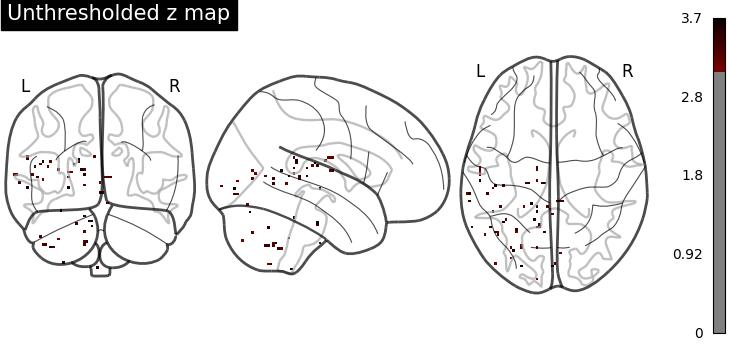

In [21]:
from IPython.display import Image
ut_list = glob.glob(os.path.join(workflow_out_dir, "secondlevel_unthresholded*.jpg"))
Image(filename=ut_list[0])

### Cluster Thresholding

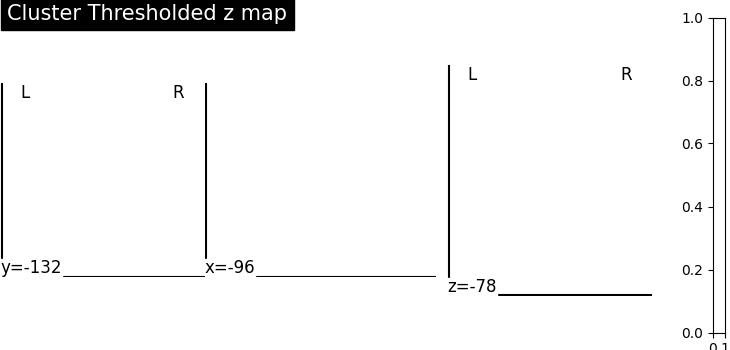

In [22]:
from IPython.display import Image
ct_list = glob.glob(os.path.join(workflow_out_dir, "secondlevel_cluster_thresholded*.jpg"))
Image(filename=ct_list[0])

### Multiple Comparison

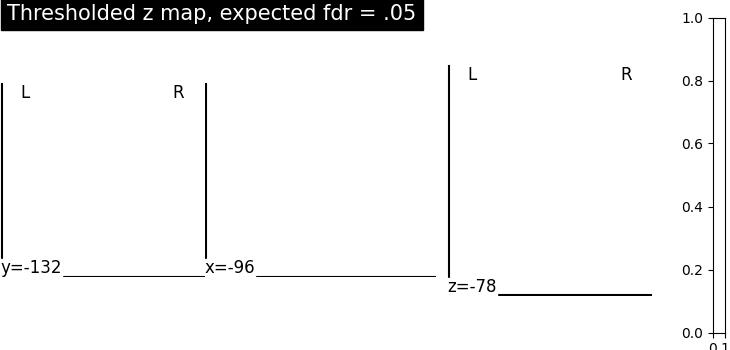

In [23]:
mc_list = glob.glob(os.path.join(workflow_out_dir, "secondlevel_multiple_comp*.jpg"))
Image(filename=mc_list[0])

### Paramatric Test

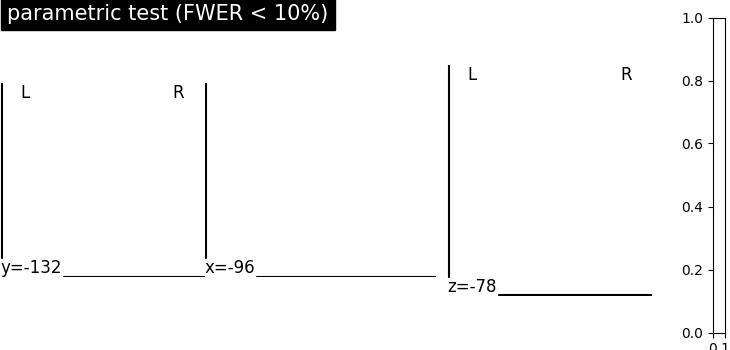

In [24]:
pt_list = glob.glob(os.path.join(workflow_out_dir, "secondlevel_paramatric*.jpg"))
Image(filename=pt_list[0])

### Nonparamatric Test

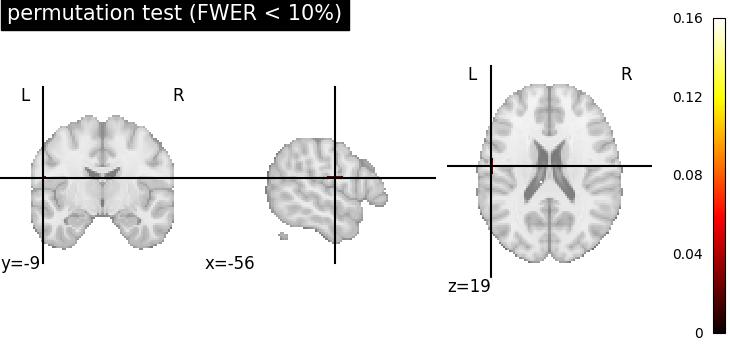

In [25]:
npt_list = glob.glob(os.path.join(workflow_out_dir, "secondlevel_permutation*.jpg"))
Image(filename=npt_list[0])

## Exercise #1

In this example, we conducted GLM on each run per subject separately and then used a fixed-effect model to average across runs. 

Where did we put `.splitter` and `.combiner`. Why did we put it there?

## Exercise #2

Moreover, We choose this approach due to limited memory on GitHub. [FirstLevelModel](https://nilearn.github.io/stable/modules/generated/nilearn.glm.first_level.FirstLevelModel.html) in Nilearn also allows to compute multiple runs with a fixed-effect model simultanously. Here is an [example](https://nilearn.github.io/stable/auto_examples/04_glm_first_level/plot_fiac_analysis.html#sphx-glr-auto-examples-04-glm-first-level-plot-fiac-analysis-py). 

Would you like to give it a try on your own?